In [1]:
from dataset import *

data_files = ['D:/senior/aiCourse/dataSource/comment_classification/output/train.json']
vocab_file = 'D:/senior/aiCourse/dataSource/comment_classification/output/vocab.txt'
label_file = 'D:/senior/aiCourse/dataSource/comment_classification/labels.txt'
enb_file = 'D:/senior/aiCourse/dataSource/comment_classification/embedding/embedding.txt'
batch_size = 128
reverse = False
split_word = True
max_len = 200

dataset1 = DataSet(  data_files,  vocab_file,   label_file,   batch_size, reverse=  reverse, split_word=  split_word, max_len=  max_len)

# vocab size:  50000
# vocab size:  20
# Start to preprocessing data...
# load data from D:/senior/aiCourse/dataSource/comment_classification/output/train.json ...
# Got 105000 data items with 820 batches


In [2]:
len(dataset1.w2i)

50000

In [3]:
def dig_lists(l):
    output = []
    for e in l:
        if isinstance(e, list):
            output += dig_lists(e)
        else:
            output.append(e)
    return(output)

In [4]:
def pad_sequences(comment_to_id,maxlen,padding,truncating):
    features = np.zeros((len(comment_to_id), maxlen), dtype=int)
    for i,comment in enumerate(comment_to_id):
        if len(comment) <= maxlen and padding == 'pre':
            features[i, -len(comment):] = np.array(comment)[:maxlen]
        if len(comment) <= maxlen and padding == 'post':
            features[i, :len(comment)] = np.array(comment)[:maxlen]
        if len(comment) > maxlen and truncating == 'post':
            features[i, :] = np.array(comment)[:maxlen]
        if len(comment) > maxlen and truncating == 'pre':
            features[i, :] = np.array(comment)[len(comment)-maxlen:]           
    return features

def split_dataset(pad_comments,labels,split_frac):
    split_index = int(len(pad_comments)*split_frac)
    data_list = list(zip(pad_comments, labels))
    random.shuffle(data_list)
    pad_comments, labels = zip(*data_list)
    x_train, x_test = pad_comments[:split_index], pad_comments[split_index:]
    y_train, y_test = labels[:split_index], labels[split_index:]
    return x_train,y_train,x_test,y_test 

In [5]:
comment_to_id = [x[0] for x in dataset1._raw_data]
pad_comments = pad_sequences(comment_to_id,maxlen=200,padding='post',truncating='post')

In [6]:
emb_dict,emb_size = load_embed_file(enb_file)

In [7]:
y_test = [x[2].flatten().tolist() for x in dataset1._raw_data]

In [8]:
import random
x_train,y_train,x_test,y_test = split_dataset(pad_comments[:10000],y_test,0.8)

In [9]:
x_train[:10]

(array([    1,   585,  1723,   384,   157,  2890,  5382,   915,    22,
         1423, 38782,   144,   683,   188,     4, 23433,  1143,   336,
        15395,  1483,   124,   133,   163,  8309, 19958,    12,    30,
          684,    12,    30,  1318,  1607,     3,   181,    12,  3822,
            3,    86,   144,  2818,    90,  4377,  1445,    70,     6,
           14,   120,   254,  1889,    61,     3,   446,   934,   338,
          485, 21756,   792,   245,    98,   299,  1818,   270,    40,
         1678,  1818,   270,   338,    66,    50,   494,    34, 10494,
           84,  2038,     3,  2666,   338,  2200,  2158,    17,   156,
         3098, 21281, 13507,    95,    47,   151,  1985,     6,     8,
          914, 10593,   202,  1399,  1247,   472,     2,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
      

# Model

In [10]:
import pandas as pd
import numpy as np

from keras.preprocessing.text import Tokenizer
from keras.engine.topology import Layer
from keras import initializers as initializers, regularizers, constraints
from keras.callbacks import Callback
from keras.layers import concatenate,GlobalMaxPooling1D,GlobalAveragePooling1D,SpatialDropout1D,Embedding, Input, Dense, LSTM, GRU, Bidirectional, TimeDistributed
from keras import backend as K
from keras.models import Model
import keras.layers as layers
from sklearn.metrics import roc_auc_score

Using TensorFlow backend.


In [11]:
batch_size = 64
epochs = 100
latent_dim = 256 # LSTM 的单元个数
num_samples = 10000 # 训练样本的大小

In [12]:
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test) 

In [17]:
def get_model():
    embed_size = 256
    inp = Input(shape=(200, ))
    x = Embedding(input_dim=len(dataset1.w2i), output_dim=embed_size,)(inp)
    print(x)
    x = SpatialDropout1D(0.2)(x)
    x = Bidirectional(GRU(120, return_sequences=True))(x)
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    conc = concatenate([avg_pool, max_pool])
    outp = Dense(80, activation="relu")(conc)
    
    model = Model(inputs=inp, outputs=outp)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

In [14]:
def build_model(): 
    input_text = layers.Input(shape=(1,), dtype="string")
    embedding = ElmoEmbeddingLayer()(input_text)
    dense = layers.Dense(256, activation='relu')(embedding)
    pred = layers.Dense(1, activation='sigmoid')(dense)

    model = Model(inputs=[input_text], outputs=pred)

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()

    return model

In [15]:
class ElmoEmbeddingLayer(Layer):
    def __init__(self, **kwargs):
        self.dimensions = 1024
        self.trainable=True
        super(ElmoEmbeddingLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.elmo = hub.Module('https://tfhub.dev/google/elmo/2', trainable=self.trainable,
                               name="{}_module".format(self.name))

        self.trainable_weights += K.tf.trainable_variables(scope="^{}_module/.*".format(self.name))
        super(ElmoEmbeddingLayer, self).build(input_shape)

    def call(self, x, mask=None):
        result = self.elmo(K.squeeze(K.cast(x, tf.string), axis=1),
                      as_dict=True,
                      signature='default',
                      )['default']
        return result

    def compute_mask(self, inputs, mask=None):
        return K.not_equal(inputs, '--PAD--')

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.dimensions)

In [18]:
model = get_model()

Tensor("embedding_2/embedding_lookup/Identity:0", shape=(?, 200, 256), dtype=float32)


In [19]:
print(model.summary())
history = model.fit(x_train, y_train,validation_data=(x_test, y_test), epochs=5,verbose=1, batch_size=100)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 200)          0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 200, 256)     12800000    input_2[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 200, 256)     0           embedding_2[0][0]                
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 200, 240)     271440      spatial_dropout1d_1[0][0]        
__________________________________________________________________________________________________
global_ave

In [20]:
import matplotlib.pyplot as plt

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


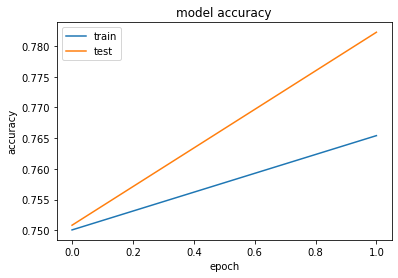

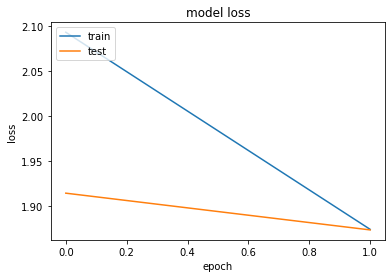

67.625


In [21]:

print(history.history.keys())
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

preds = model.predict(x_train)
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])
print(accuracy(preds,y_train))

In [22]:
def convert_2_labels(answer):
    labels_input = []
    for item in answer:
        answer_temp = []
        for i in range(0,80,4):
            answer_temp.append(np.argmax(item[i:i+4]))
        labels_input.append(answer_temp)
    return labels_input



In [23]:
convert_2_labels(preds)

[[3, 0, 3, 0, 3, 0, 2, 3, 3, 3, 0, 0, 3, 3, 3, 1, 1, 3, 1, 3],
 [3, 0, 3, 0, 3, 0, 2, 3, 3, 3, 0, 0, 3, 3, 3, 1, 1, 3, 1, 3],
 [3, 0, 3, 0, 3, 0, 2, 3, 3, 3, 0, 0, 3, 3, 3, 1, 1, 3, 1, 3],
 [3, 0, 3, 0, 3, 0, 2, 3, 3, 3, 0, 0, 3, 3, 3, 0, 1, 3, 1, 3],
 [3, 0, 3, 0, 3, 0, 2, 3, 3, 3, 0, 0, 3, 3, 3, 1, 1, 3, 1, 3],
 [3, 0, 3, 0, 3, 0, 2, 3, 3, 3, 0, 0, 3, 3, 3, 1, 1, 3, 1, 3],
 [3, 0, 3, 0, 3, 0, 2, 3, 3, 3, 0, 0, 3, 3, 3, 1, 1, 3, 1, 3],
 [3, 0, 3, 0, 3, 0, 2, 3, 3, 3, 0, 0, 3, 3, 3, 1, 1, 3, 1, 3],
 [3, 0, 3, 0, 3, 0, 2, 3, 3, 3, 0, 0, 3, 3, 3, 1, 1, 3, 1, 3],
 [3, 0, 3, 0, 3, 0, 2, 3, 3, 3, 0, 0, 0, 0, 3, 1, 1, 3, 1, 3],
 [3, 0, 3, 0, 3, 0, 2, 3, 3, 3, 0, 0, 0, 0, 3, 1, 1, 3, 1, 3],
 [3, 0, 3, 0, 3, 0, 2, 3, 3, 3, 0, 0, 3, 3, 3, 1, 1, 3, 1, 3],
 [3, 0, 3, 0, 3, 0, 2, 3, 3, 3, 0, 0, 3, 3, 3, 0, 1, 3, 1, 3],
 [3, 0, 3, 0, 3, 0, 2, 3, 3, 3, 0, 0, 3, 3, 3, 0, 1, 3, 1, 3],
 [3, 0, 3, 0, 3, 0, 2, 3, 3, 3, 0, 0, 3, 3, 3, 1, 1, 3, 1, 3],
 [3, 0, 3, 0, 3, 0, 2, 3, 3, 3, 0, 0, 3, 3, 3, 1, 1, 3,

In [24]:
coun=0
all1=0
for line in convert_2_labels(y_train):
    for item in line:
        if item == 3:
            coun+=1
        all1+=1

In [25]:
coun/all1

0.615875